In [1]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler

# Background

Here we clean our Video2Data output data for machine learning applications.

## The Process

1. Filter out ineligible videos
    - Confirm that *n_frames* are available (using the leg kick as the end frame)
    - Confirm that the angle between knees is between 40-90 degrees in the end frame
    
    
2. Prune JSONs
    - Pick out the frames within the selected range
    - Select the keypoints that we want to include in the model
    
    
3. Clean out zeroes and missing values
    - We use pd.Series.interpolate() to impute these values

    
4. Normalize data
    - The max and min x and y coordinates for all keypoints across the selected 15 frames are used to normalize x and y values, per pitch, respectfully. This is not to be confused with the scaling that is later performed during the modeling stage.


5. Outcomes are joined to each feature set
    - Due to the large variety of pitches we categorize all pitches into three bins:
        - **Fastball (FB)**: Four-seam fastballs
        - **Fastball with Movement (FBwM)**: Two-seam fastballs, Cutters, Sinkers, Split-fingered fastballs
        - **Off-Speed (OFF)**: Change-ups and breaking pitches


# Functions

In [2]:
# In function parameters
N_FRAMES = 15
FRAMES_AFTER_KNEE_APEX = 2
Y_CHANGE_TRESH = 0.12
ZERO_FRACTION_THRESH = 0.2

In [3]:
def get_frame_range(openpose_dict):
    
    # Convert knee data to data frame
    df = pd.DataFrame(openpose_dict['LKnee'])
    df = df[df.conf > 0] # Remove any frames where LKnee 
    y_vals = df['y'].tolist()
    
    # Calculate a rolling percent change in y of the knee
    rolling_perc_change_y = []
    for i, y in enumerate(y_vals):
        if i != len(y_vals) - 1:
            change = abs(y_vals[i+1] - y_vals[i])/y_vals[i]
            rolling_perc_change_y.append(change)
            
    # Determine if y changes by more than 12% from any frame to the next (if so save frame number)
    outlier_frame = 0
    change_y_thresh = Y_CHANGE_TRESH
    for i, perc_change_y in enumerate(rolling_perc_change_y, 1):
        if perc_change_y > change_y_thresh:
            outlier_frame = i-1
            break
    
    # If y changes by more than 12%, subset df
    if outlier_frame:
        df = df.head(outlier_frame)
    
    # Set the end frame at which y is minimum (this is the leg kick frame)
    leg_kick_frame = df[df.y == min(df.y)]['frame'].tolist()[0]
    end_frame = leg_kick_frame + FRAMES_AFTER_KNEE_APEX
    start_frame = end_frame - (N_FRAMES-1) # Include n_frames from 
    
    return start_frame, end_frame


def get_frame_range_index(openpose_dict, start_frame):
    
    # Find frame where LKnee is highest
    # NOTE: Origin of image is top left, so y is reversed (y_min = y when knee is highest)
    frame_list = openpose_dict['LKnee']['frame']
    start_idx = 0
    for i, frame in enumerate(frame_list):
        if frame == start_frame:
            start_idx = i
            break
        else:
            continue
    assert(openpose_dict['LKnee']['frame'][start_idx] == start_frame)
    end_idx = start_idx + (N_FRAMES-1)
    return start_idx, end_idx
    

def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang


def get_RKnee_LKnee_angle(openpose_dict, leg_kick_idx):
    '''
    Source: https://manivannan-ai.medium.com/find-the-angle-between-three-points-from-2d-using-python-348c513e2cd
    '''
    rknee_coords = (openpose_dict['RKnee']['x'][leg_kick_idx], 1 - openpose_dict['RKnee']['y'][leg_kick_idx])
    lknee_coords = (openpose_dict['LKnee']['x'][leg_kick_idx], 1 - openpose_dict['LKnee']['y'][leg_kick_idx])
    third_point = (lknee_coords[0], rknee_coords[1])
    return getAngle(a=third_point, b=rknee_coords, c=lknee_coords)


def video_link_from_play_id(pitcher, lookup_play_id):

    url_json = '../data/video-url-json/NNextPitchURLs.json'
    with open(url_json) as f:
        url_dict = json.load(f)

    player_dict = url_dict[pitcher]

    video_idx = 0
    for i, play_id in enumerate(player_dict['play_ids']):
        if play_id == lookup_play_id:
            video_idx = i
            break

    return player_dict['video_urls'][video_idx]


def json_filter(json_files, pitcher):

    # Lists to store selected and deselected files
    selected_files = []
    deselected_files = {
        "no_frames_avail": [],
        "missingness": [],
        "frame_range": [],
        "invalid_angle_at_apex": []
    }

    # Loop through JSONs
    for file in json_files:
        f = open(file)
        openpose_dict = json.load(f)
        play_id = file.split(".json")[0].split("/")[-1]

        # Start filtering process by ensuring openpose_dict['LKnee']['frame'] is not empty
        if openpose_dict['LKnee']['frame']:
            
            # Filter out files with 0s in >ZERO_FRACTION_THRESH*100% of frames
            n_zeroes = openpose_dict['LKnee']['frame'].count(0)
            n_frames = len(openpose_dict['LKnee']['frame'])
            max_zeroes = n_frames * ZERO_FRACTION_THRESH
            if n_zeroes > max_zeroes:
                print(file)
                print(
                    f">{int(ZERO_FRACTION_THRESH*100)}% ({n_zeroes}/{n_frames} frames) of frames are 0. " \
                    f"Deselecting file...")
                print(video_link_from_play_id(pitcher, lookup_play_id=play_id) + "\n")
                deselected_files["missingness"].append(file)
                
            else:
                # Check that there are enough frames
                first_frame_avail = min(openpose_dict['LKnee']['frame'])
                last_frame_avail = max(openpose_dict['LKnee']['frame'])
                start_frame, end_frame = get_frame_range(openpose_dict)
                leg_kick_frame = end_frame - FRAMES_AFTER_KNEE_APEX
                
                # Enough frames at the beginning
                if start_frame < first_frame_avail:
                    print(file)
                    print(
                        f"Not enough frames available... " \
                        f"Start Frame: {start_frame}, 1st Avail: {first_frame_avail}")
                    print(video_link_from_play_id(pitcher, lookup_play_id=play_id) + "\n")
                    deselected_files["frame_range"].append(file)
                
                # Enough frames at the end
                elif end_frame > last_frame_avail:
                    print(file)
                    print(
                        f"Not enough frames available... " \
                        f"End Frame: {end_frame}, Last Avail: {last_frame_avail}")
                    print(video_link_from_play_id(pitcher, lookup_play_id=play_id) + "\n")
                    deselected_files["frame_range"].append(file)

                # If there are enough frames available...
                else:

                    # Confirm that the pitcher in the correct position in the end frame
                    # The correct position is confirmed by there being a 45-90 degree angle between knees 
                    start_idx, end_idx = get_frame_range_index(openpose_dict, start_frame)
                    leg_kick_idx = end_idx - FRAMES_AFTER_KNEE_APEX
                    angle = get_RKnee_LKnee_angle(openpose_dict=openpose_dict, leg_kick_idx=leg_kick_idx)

                    # Select file if the angle is between 40-90 degrees
                    if angle < 90 and angle > 40:
                        selected_files.append(file)

                    # Otherwise deselect
                    else:
                        print(file)
                        print(f"{round(angle, 1)}° angle between knees. Deselecting file...")
                        print(f"Leg kick frame: {leg_kick_frame}")
                        print(video_link_from_play_id(pitcher, lookup_play_id=play_id) + "\n")
                        deselected_files["invalid_angle_at_apex"].append(file)
                    
        # If openpose_dict['LKnee']['frame'] is empty then then pitcher was found in 0 frames    
        else:
            print(file)
            print(f"JSON empty, likely due to there being 0 frames with a detected pitcher. Deselecting file...")
            print(video_link_from_play_id(pitcher, lookup_play_id=play_id) + "\n")
            deselected_files["no_frames_avail"].append(file)
            
    
    return selected_files, deselected_files


def normalize(vals: list):
    '''
    Normalize each value in a list to between 0 and 1
    x_i = (x_i - x_min) / (x_max - x_min)
    '''
    
    # Get min and min_max_range
    val_min = min(vals)
    val_max = max(vals)
    min_max_range = val_max - val_min

    # Can't divide by 0; Replace min max range with small number if 0
    # Hypothetically the numerator will have to be 0 if min max range is 0
    if min_max_range == 0:
        min_max_range = 0.0001
        
    return [(val_i - val_min)/min_max_range for val_i in vals]


def normalize_to_crop(vals: list, val_min: float, val_max: float):
    return [(val_i - val_min)/(val_max - val_min) for val_i in vals]


def time_plots(output_dict: dict):

    bodyparts = [
        'Neck', 'RWrist',
        'LHip', 'LKnee', 'LAnkle',
        'RShoulder', 'RElbow', 'RHip', 'RKnee', 'RAnkle']

    for bodypart in bodyparts:
        df = pd.DataFrame()
        for play_id in list(output_dict.keys()):
            df = pd.concat([df, pd.DataFrame(output_dict[play_id][bodypart])])
        melted_df = df[['time', 'x', 'y']].melt(id_vars='time')
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
        sns.lineplot(data=melted_df, x='time', y='value', hue='variable')
        ax.set_title(bodypart)
        plt.show()
        
        
def time_plots_by_pitch(output_dict: dict, pitchtype_dict: dict, line_or_box: str):

    bodyparts = [
        'Neck', 'RWrist',
        'LHip', 'LKnee', 'LAnkle',
        'RShoulder', 'RElbow', 'RHip', 'RKnee', 'RAnkle']
    
    for bodypart in bodyparts:
        df = pd.DataFrame()
        for play_id in list(output_dict.keys()):
            temp_df = pd.DataFrame(output_dict[play_id][bodypart])
            temp_df['play_id'] = play_id
            temp_df['pitch_type'] = pitchtype_dict[play_id]
            df = pd.concat([df, temp_df])
    
        x_df = df[['time', 'x', 'pitch_type']]
        y_df = df[['time', 'y', 'pitch_type']]
        
        if line_or_box == "line":
            fig, axs = plt.subplots(1, 2, figsize=(16, 4))
            sns.lineplot(data=x_df, x='time', y='x', hue='pitch_type', ax=axs[0])
            sns.lineplot(data=y_df, x='time', y='y', hue='pitch_type', ax=axs[1])
            axs[0].set_title(f"{bodypart}, x Coordinate Over Time")
            axs[1].set_title(f"{bodypart}, y Coordinate Over Time")
            plt.show()
        
        if line_or_box == "box":
            fig, axs = plt.subplots(1, 2, figsize=(16, 4))
            sns.boxplot(data=x_df, x='time', y='x', hue='pitch_type', ax=axs[0])
            sns.boxplot(data=y_df, x='time', y='y', hue='pitch_type', ax=axs[1])
            axs[0].set_title(f"{bodypart}, x Coordinate Over Time")
            axs[1].set_title(f"{bodypart}, y Coordinate Over Time")
            plt.show()            
        
        
def clean_video2data_data(json_files: list, pitch_hand: str, pitcher: str):
    
    # Check parameters
    assert pitch_hand in ['r', 'l'], "pitch_hand argument must be either 'r' or 'l'"

    # Filter out invalid videos
    print(f'Filtering files...\n')
    selected_files, deselected_files = json_filter(json_files=json_files, pitcher=pitcher)

    # Set up output
    output = {}

    # Prune, clean, transform and normalize data
    for file in selected_files:

        f = open(file)
        openpose_dict = json.load(f)
        start_frame, end_frame = get_frame_range(openpose_dict)
        start_idx, end_idx = get_frame_range_index(openpose_dict, start_frame)

        bodyparts = [
            'Neck',
            'LHip', 'LKnee', 'LAnkle',
            'RHip', 'RKnee', 'RAnkle']

        if pitch_hand == 'r':
            bodyparts = bodyparts + ['RWrist', 'RShoulder', 'RElbow']

        if pitch_hand == 'l':
            bodyparts = bodyparts + ['LWrist', 'LShoulder', 'LElbow']

        # Prune dictionary
        # 1) Remove unnecessary keypoint positions
        all_keypoints = list(openpose_dict.keys())
        rm_keypoints = [point for point in all_keypoints if point not in bodyparts]
        for key in rm_keypoints:
            del openpose_dict[key]

        # 2) Crop all frames to n_frames between start frame and end frame
        for bodypart in bodyparts:
            openpose_dict[bodypart]['frame'] = openpose_dict[bodypart]['frame'][start_idx:end_idx+1]
            openpose_dict[bodypart]['x'] = openpose_dict[bodypart]['x'][start_idx:end_idx+1]
            openpose_dict[bodypart]['y'] = openpose_dict[bodypart]['y'][start_idx:end_idx+1]
            openpose_dict[bodypart]['conf'] = openpose_dict[bodypart]['conf'][start_idx:end_idx+1]

        # Ensure that there N_FRAMES worth of frames in the data frame
        # A missing frame would likely result from a pitcher going undetected by the Detectron2 model
        assert len(openpose_dict['Neck']['frame']) == N_FRAMES, f"Less than {N_FRAMES} frames in {file}"

        # Interpolate missing values for each key point
        for bodypart in bodyparts:
            if openpose_dict[bodypart]['x'].count(0):

                # Message
                print(file)
                print(f"Interpolating values for {openpose_dict[bodypart]['x'].count(0)} frame(s) of {bodypart}...\n")

                # dict -> df -> interpolated_df -> dict
                openpose_df = pd.DataFrame(openpose_dict[bodypart])
                openpose_df.replace(0, np.nan, inplace=True)
                openpose_df.interpolate(inplace=True)
                openpose_dict[bodypart] = openpose_df.to_dict(orient='list')

        # Convert y to interpretable y
        for bodypart in bodyparts:
            openpose_dict[bodypart]['y'] = [720 - y for y in openpose_dict[bodypart]['y']]

        # Get x, y max and min for full pitch (this should represent the crop to normalize to)
        x_min, x_max, y_min, y_max = 1280, 0, 720, 0
        for bodypart in bodyparts:
            if min(openpose_dict[bodypart]['x']) < x_min:
                x_min = min(openpose_dict[bodypart]['x'])
            if max(openpose_dict[bodypart]['x']) > x_max:
                x_max = max(openpose_dict[bodypart]['x'])
            if min(openpose_dict[bodypart]['y']) < y_min:
                y_min = min(openpose_dict[bodypart]['y'])
            if max(openpose_dict[bodypart]['y']) > y_max:
                y_max = max(openpose_dict[bodypart]['y'])

        # Normalize x and y values to the crop space
        for bodypart in bodyparts:
            openpose_dict[bodypart]['x'] = normalize_to_crop(openpose_dict[bodypart]['x'], val_min=x_min, val_max=x_max)
            openpose_dict[bodypart]['y'] = normalize_to_crop(openpose_dict[bodypart]['y'], val_min=y_min, val_max=y_max)

        # Normalize values to be between 0 and 1
        #for bodypart in bodyparts:
        #    openpose_dict[bodypart]['x'] = normalize(openpose_dict[bodypart]['x'])
        #    openpose_dict[bodypart]['y'] = normalize(openpose_dict[bodypart]['y'])

        # Set common times for all files
        for bodypart in bodyparts:
            openpose_dict[bodypart]['time'] = np.arange(1, N_FRAMES+1).tolist()

        # Save cleaned data
        play_id = file.split("/")[-1].split(".json")[0]
        output[play_id] = openpose_dict

    print("Files pruned, missing values interpolated and x, y coordinates normalized...\n")
    
    print(f"{len(selected_files)}/{len(json_files)} ({round(len(selected_files)*100/len(json_files), 1)}%) files remain after filter...")

    return output, deselected_files        
        

# Video2Data Data Cleaning

## Glasnow

In [4]:
# Parameters and inputs
pitcher = 'Tyler Glasnow'
pitch_hand = 'r'
json_dir = '../data/openpose-json-data/glasnow'
json_files = [os.path.join(json_dir, file) for file in os.listdir(json_dir) if '.json' in file]

# Send files through filter and cleaner
glasnow_clean_data, glasnow_deselected_files = clean_video2data_data(json_files, pitch_hand, pitcher)

Filtering files...

../data/openpose-json-data/glasnow/32fecce3-24d6-4506-8082-3f9e41e8a1a0.json
Not enough frames available... Start Frame: -3, 1st Avail: 1
https://sporty-clips.mlb.com/c698c60c-1c90-4497-85f3-7fc723670811.mp4

../data/openpose-json-data/glasnow/71a98d14-9574-4fc1-abc0-10fd553fe44b.json
Not enough frames available... Start Frame: 18, 1st Avail: 30
https://sporty-clips.mlb.com/289c1525-4e93-4683-b5a9-ea504f6ac974.mp4

../data/openpose-json-data/glasnow/bdb39399-66f2-486b-8b9e-90e37179b344.json
Not enough frames available... Start Frame: 17, 1st Avail: 22
https://sporty-clips.mlb.com/61c9db2d-54e2-4ada-a680-93f799596af7.mp4

../data/openpose-json-data/glasnow/f7991a04-ee56-4f4e-893b-113bb64170ee.json
Not enough frames available... Start Frame: 19, 1st Avail: 30
https://sporty-clips.mlb.com/223f7696-d4c1-46a4-872d-caf50990f6cd.mp4

../data/openpose-json-data/glasnow/2fdf308d-5e16-4c50-87dd-5155e8617ad5.json
Not enough frames available... Start Frame: 20, 1st Avail: 23
ht

../data/openpose-json-data/glasnow/93b24d13-ac41-41b9-a7d4-1b47cdc429d8.json
Not enough frames available... Start Frame: 21, 1st Avail: 23
https://sporty-clips.mlb.com/2df2e889-b5a6-4542-9ad1-97cb902e35a9.mp4

../data/openpose-json-data/glasnow/cf18caf5-ce55-4ccd-81ee-6c44059adfc4.json
Not enough frames available... Start Frame: 20, 1st Avail: 21
https://sporty-clips.mlb.com/97c821b3-9dd5-4811-8336-128f59bb47c6.mp4

../data/openpose-json-data/glasnow/82e635db-a747-43c2-a78f-eb339b271089.json
Not enough frames available... Start Frame: 22, 1st Avail: 34
https://sporty-clips.mlb.com/fd30154f-a7dc-47a1-9f61-87da17ed8bc1.mp4

../data/openpose-json-data/glasnow/0d31f9f2-4b54-4fb6-af1b-62005bd6e757.json
Not enough frames available... Start Frame: 19, 1st Avail: 26
https://sporty-clips.mlb.com/62e8e1cf-e0b6-4129-8921-bd25d31f222b.mp4

../data/openpose-json-data/glasnow/e6e8d7c6-ed0c-41fb-b953-d2f811ab391a.json
27.6° angle between knees. Deselecting file...
Leg kick frame: 27
https://sporty-cl

https://sporty-clips.mlb.com/11923b12-9128-4b81-9200-3922f6147cf9.mp4

../data/openpose-json-data/glasnow/384970b3-5181-48d2-83a1-b22617b2c4a7.json
Not enough frames available... Start Frame: 20, 1st Avail: 24
https://sporty-clips.mlb.com/0312c952-faba-4326-a382-eeca47bfc481.mp4

../data/openpose-json-data/glasnow/680fcac5-bbb2-4053-9707-dfbeac7859a3.json
Not enough frames available... Start Frame: 20, 1st Avail: 25
https://sporty-clips.mlb.com/09c0e5e2-479a-4d9d-bb0c-6ab06909b5e6.mp4

../data/openpose-json-data/glasnow/8905541c-ce90-4a81-a782-d940eb66f87b.json
Not enough frames available... Start Frame: 15, 1st Avail: 24
https://sporty-clips.mlb.com/f8bc68d5-a083-4ef7-8d33-3d47e31e989f.mp4

../data/openpose-json-data/glasnow/9ea8506f-93a5-48dc-82b8-7a9f5666037b.json
Not enough frames available... Start Frame: 20, 1st Avail: 32
https://sporty-clips.mlb.com/1e1e9ab1-7c41-427f-bf4f-5925754d791a.mp4

../data/openpose-json-data/glasnow/9628c700-c8c3-4b78-ad86-12a84f170077.json
Not enough f

../data/openpose-json-data/glasnow/e84f77a8-ffce-4b61-83e4-0a632fcad209.json
Not enough frames available... Start Frame: 20, 1st Avail: 32
https://sporty-clips.mlb.com/7366df16-cab6-4e40-980c-dfd6781d5b5b.mp4

../data/openpose-json-data/glasnow/5a71202b-f4f3-4f5d-869b-c7d9245788a1.json
Not enough frames available... Start Frame: 19, 1st Avail: 22
https://sporty-clips.mlb.com/74e365e0-bc37-4f28-aa50-db6b4c50acf0.mp4

../data/openpose-json-data/glasnow/e1fc56cd-e4f1-4971-be61-336218659751.json
Not enough frames available... Start Frame: 20, 1st Avail: 23
https://sporty-clips.mlb.com/b542e5a5-cca5-43c8-907c-a06d491193a1.mp4

../data/openpose-json-data/glasnow/aa9d13f2-ecba-41f6-9d7b-4b08de814eb7.json
Not enough frames available... Start Frame: 38, 1st Avail: 39
https://sporty-clips.mlb.com/d2760027-6451-4720-908d-0b7e87f440d9.mp4

../data/openpose-json-data/glasnow/a9153132-c4b9-4afa-a981-fb961e631f52.json
Not enough frames available... Start Frame: 33, 1st Avail: 39
https://sporty-clips.

../data/openpose-json-data/glasnow/7c159978-eaba-4e6d-bc95-25b49f3c6f3d.json
Interpolating values for 1 frame(s) of LKnee...

../data/openpose-json-data/glasnow/7c159978-eaba-4e6d-bc95-25b49f3c6f3d.json
Interpolating values for 1 frame(s) of LAnkle...

../data/openpose-json-data/glasnow/3bc03c6b-1463-430c-82a9-4db2ddf04a9b.json
Interpolating values for 1 frame(s) of LAnkle...

../data/openpose-json-data/glasnow/2b5d9c5f-0f60-4745-890e-aec826b5ffd7.json
Interpolating values for 1 frame(s) of LAnkle...

Files pruned, missing values interpolated and x, y coordinates normalized...

726/903 (80.4%) files remain after filter...


In [5]:
# Get tabular data - the pitch type is held within this file
glasnow_df = pd.read_csv("../data/tabular-data/607192_data.csv")
glasnow_df = glasnow_df[glasnow_df.play_ids.isin(list(glasnow_clean_data.keys()))]
glasnow_df["pitch_type"].value_counts()

FF    470
CU    224
CH     31
Name: pitch_type, dtype: int64

In [6]:
# Create dictionaries that map video data to a pitch type
# Categorized pitches
glasnow_pitchtype_dict = {}
for i, play_id in enumerate(list(glasnow_df["play_ids"])):
    pitch_type = list(glasnow_df["pitch_type"])[i]
    if pitch_type in ["FA", "FF"]:
        pitch_type = "FB"
    elif pitch_type in ["FT", "FC", "FS", "SI", "SF"]:
        pitch_type = "FBwM"
    else:
        pitch_type = "OFF"
    glasnow_pitchtype_dict[play_id] = pitch_type
    
# All pitch types
glasnow_pitchtype_all_dict = {}
for i, play_id in enumerate(list(glasnow_df["play_ids"])):
    pitch_type = list(glasnow_df["pitch_type"])[i]
    glasnow_pitchtype_all_dict[play_id] = pitch_type
    

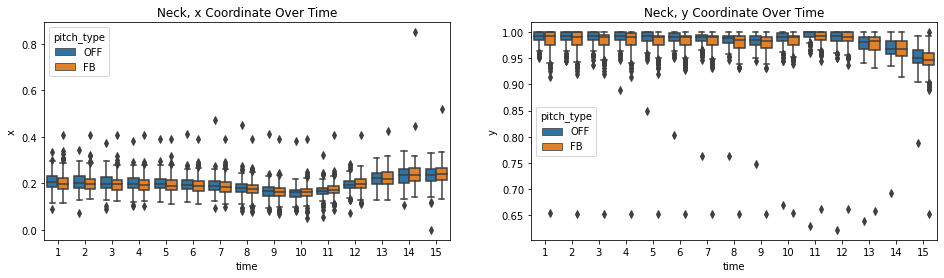

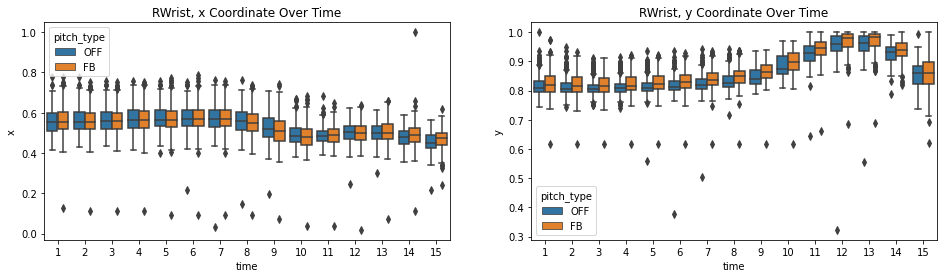

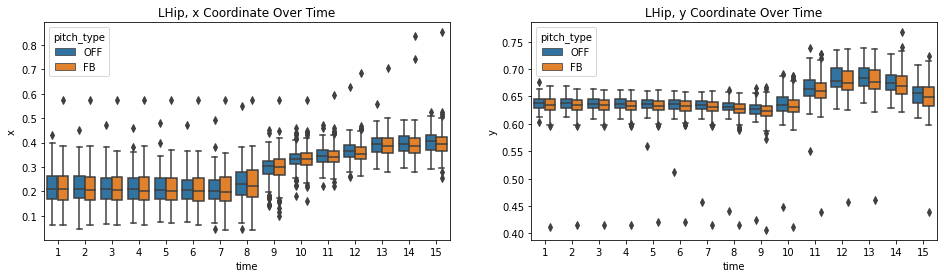

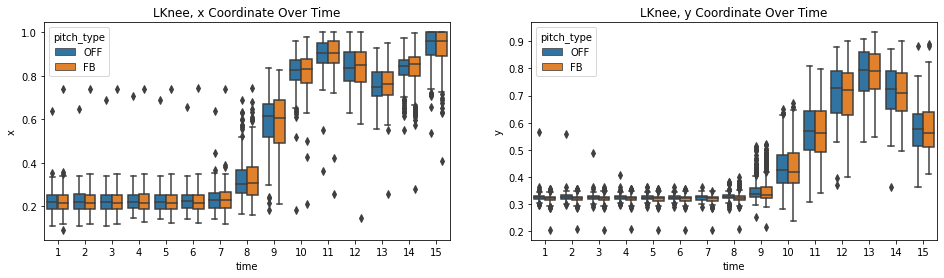

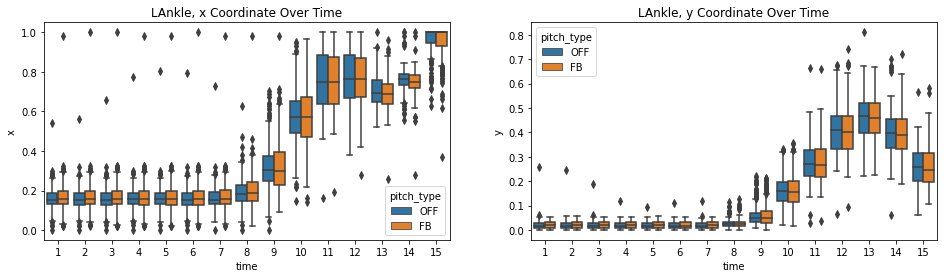

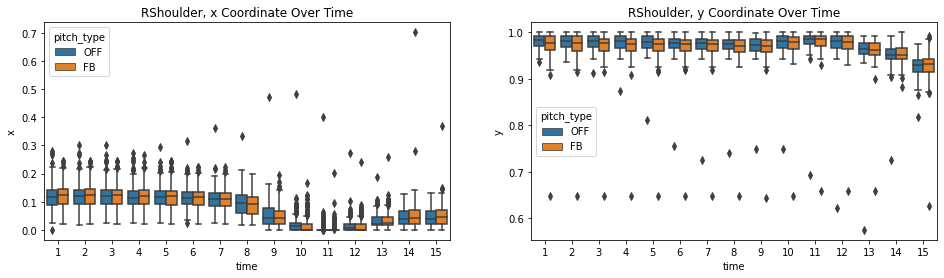

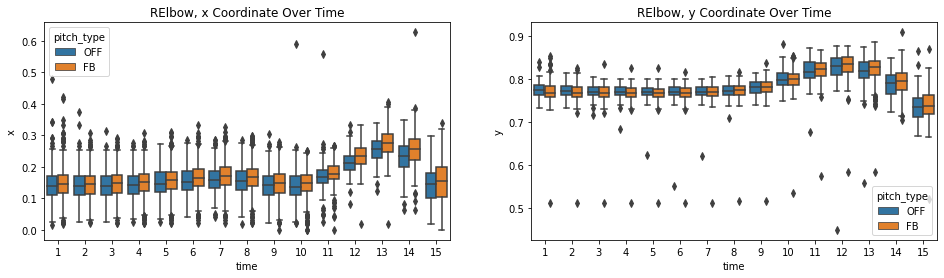

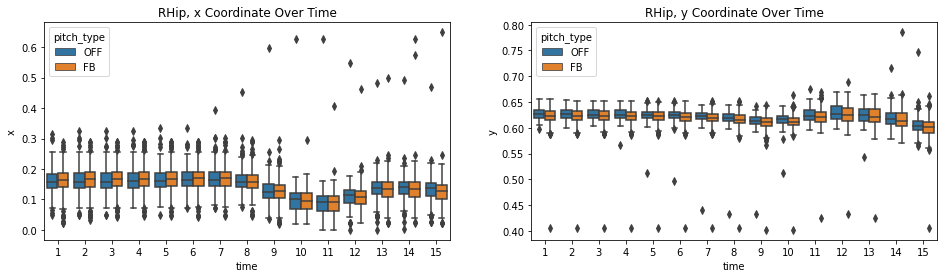

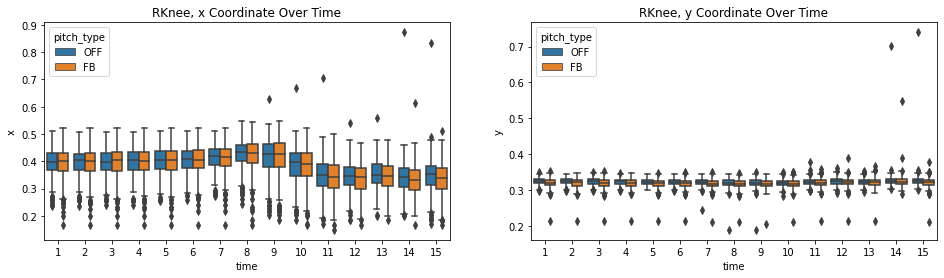

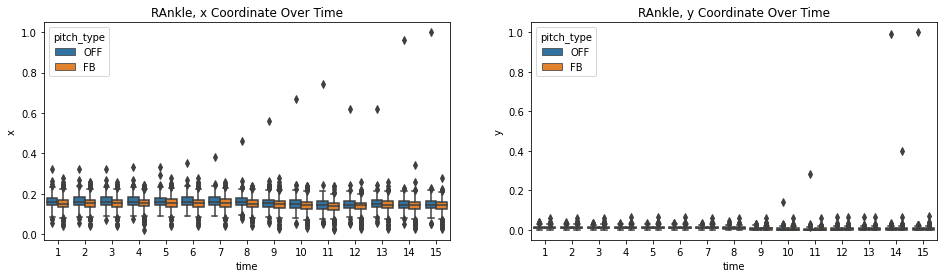

In [7]:
time_plots_by_pitch(glasnow_clean_data, glasnow_pitchtype_dict, "box")

### Manual Inspection for Errors

In [8]:
# The code below was used to manually inspect all observations for errors - commenting out to reduce memory
#for play_id in glasnow_clean_data.keys():

    ## Create df
    #temp_df = pd.DataFrame(glasnow_clean_data[play_id]['LKnee'])
    #melted_df = temp_df[['time', 'x', 'y']].melt(id_vars='time')

    ## Plot
    #print(play_id)
    #print(video_link_from_play_id(pitcher, lookup_play_id=play_id) + "\n")
    #fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    #sns.lineplot(data=melted_df, x='time', y='value', hue='variable')
    #ax.set_title(play_id)
    #plt.show()
    

In [9]:
glasnow_manual_errors = [
    "8d2f72cb-a3d7-4bf8-aabb-59078dc5c6bb",
    "6d9cccfe-f1d4-4df7-a162-e66b5a3de09b",
    "5247a41c-d57e-4f2f-9629-4fe793c39e6f",
    "7c159978-eaba-4e6d-bc95-25b49f3c6f3d",
    "9be862bd-81af-459d-a9ef-67743e2ee9a7",
    "c33c44ab-01e8-48b7-9dae-7b62aa8806c1"
]

In [10]:
len(glasnow_clean_data.keys())

726

In [11]:
for play_id in glasnow_manual_errors:
    glasnow_clean_data.pop(play_id)

In [12]:
len(glasnow_clean_data.keys())

720

### Frame-to-Frame Comparison by Pitch Type

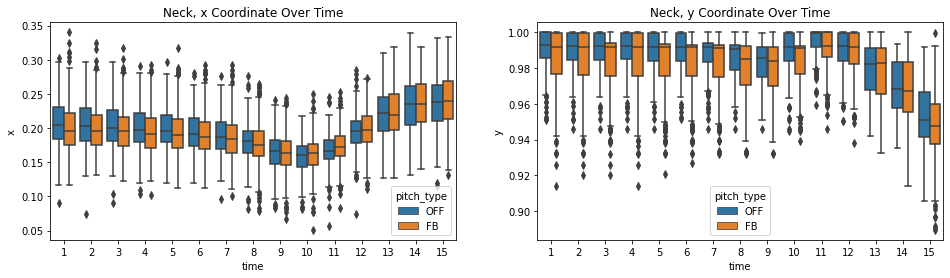

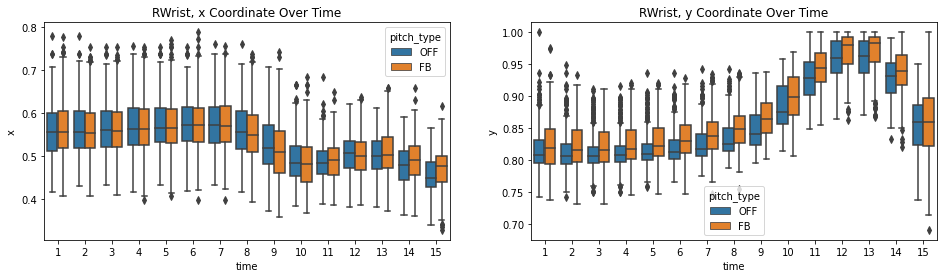

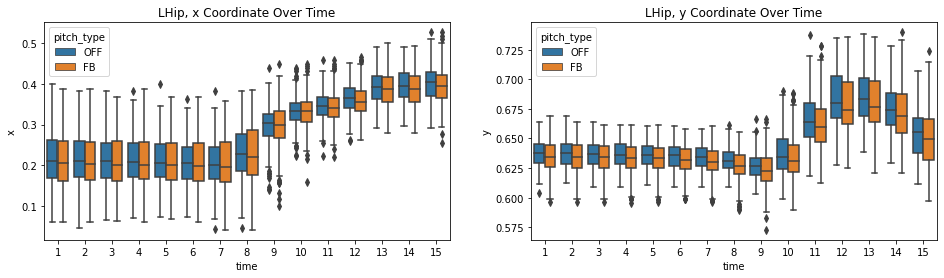

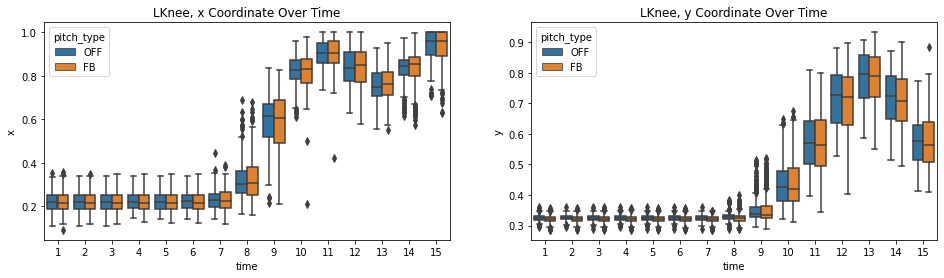

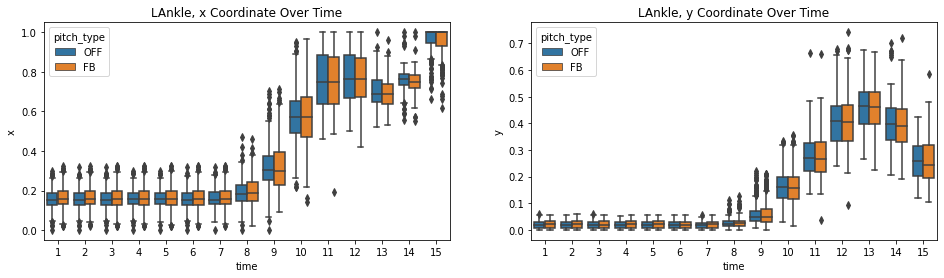

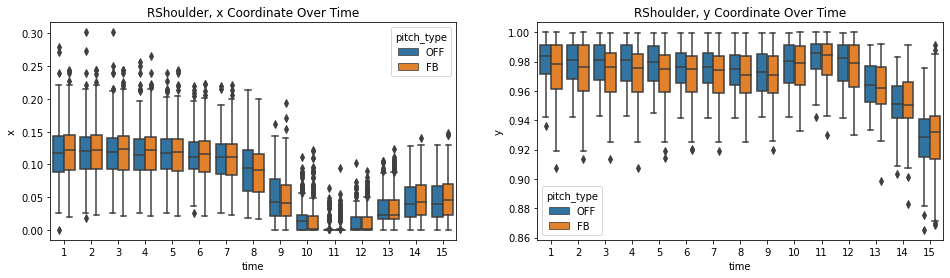

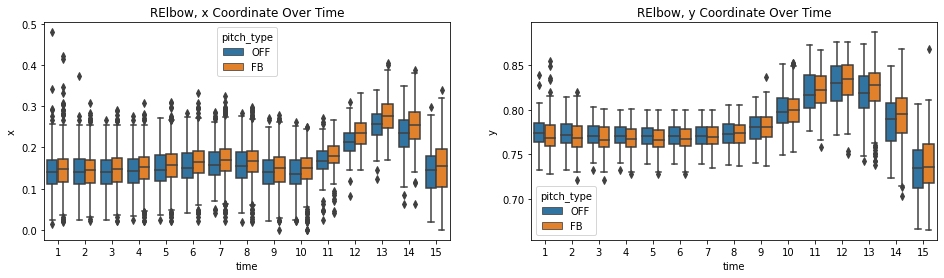

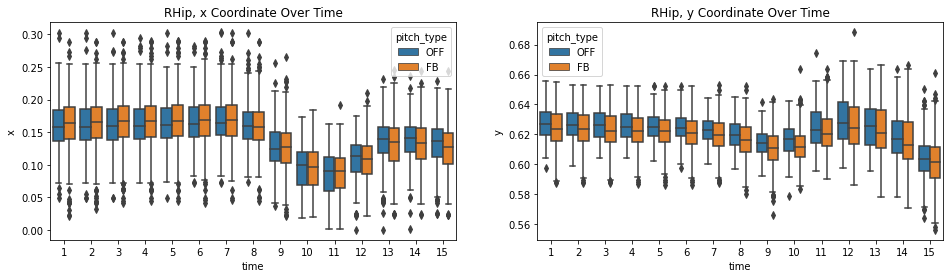

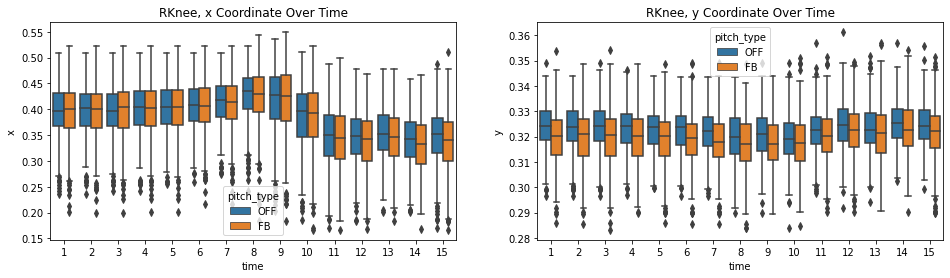

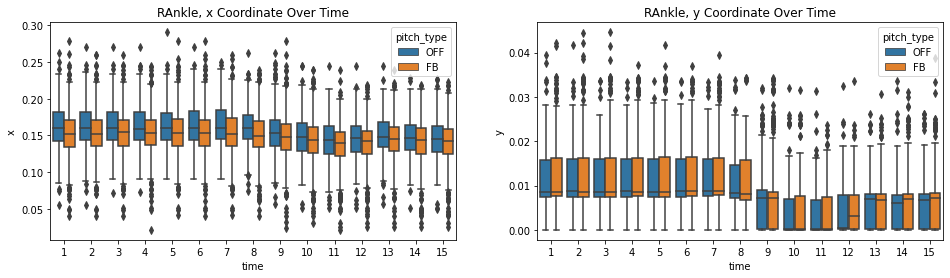

In [13]:
time_plots_by_pitch(glasnow_clean_data, glasnow_pitchtype_dict, "box")

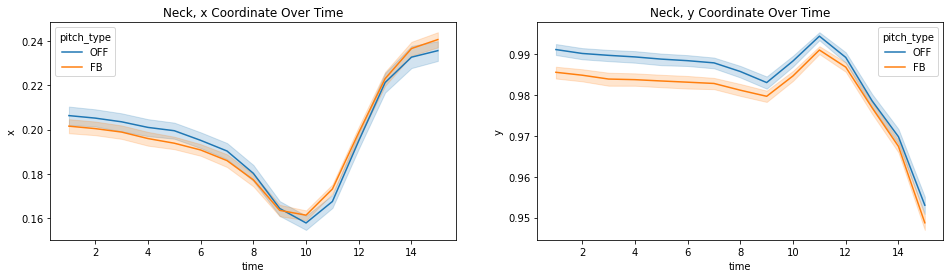

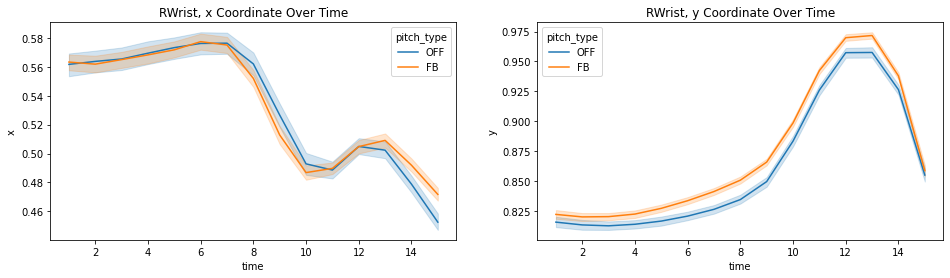

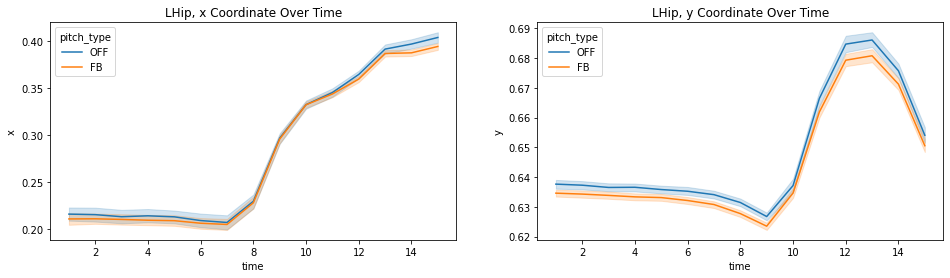

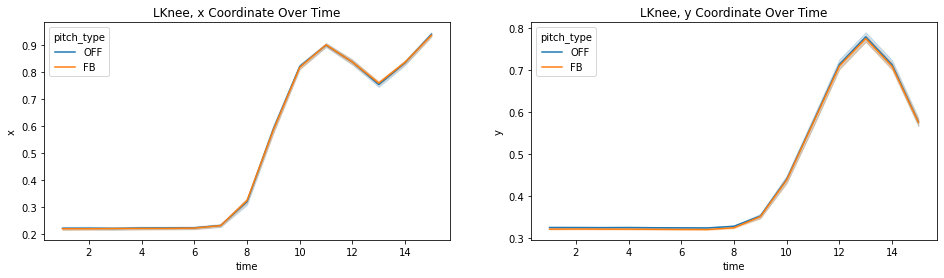

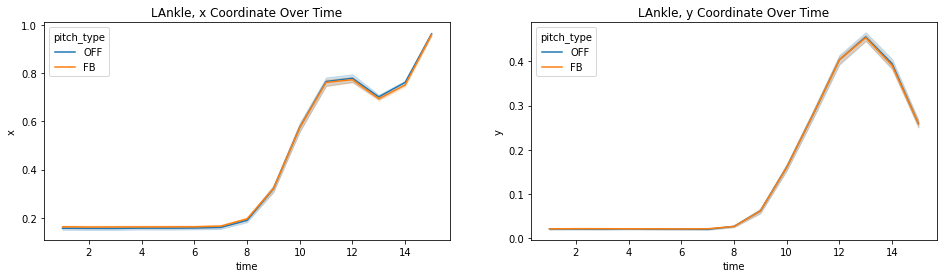

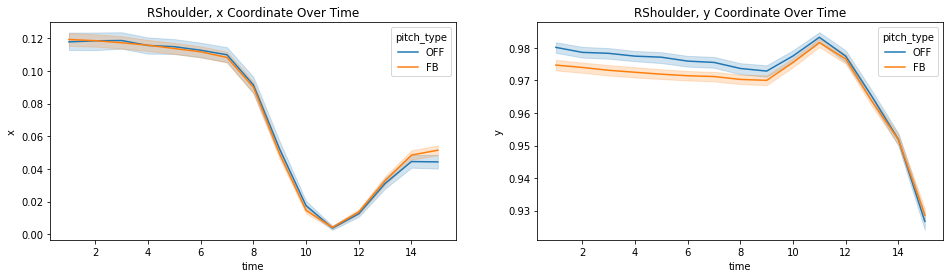

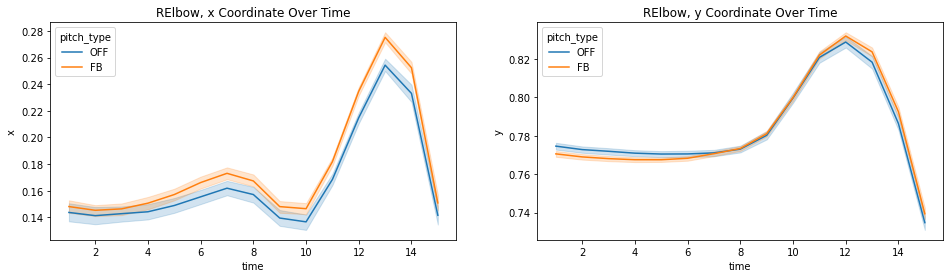

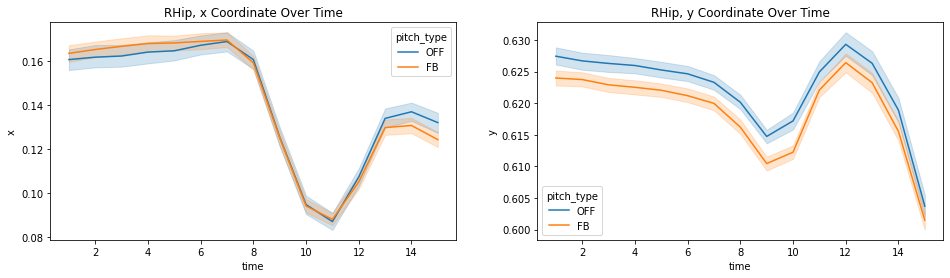

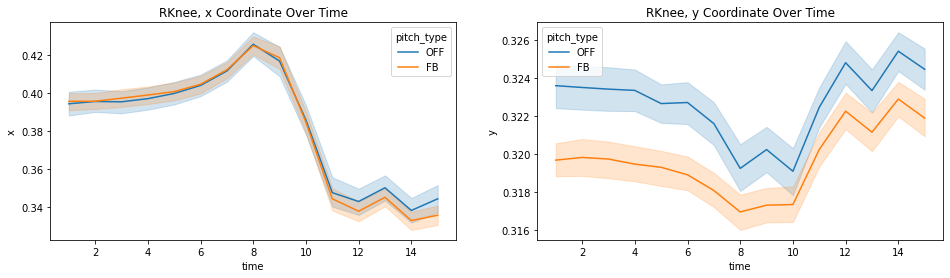

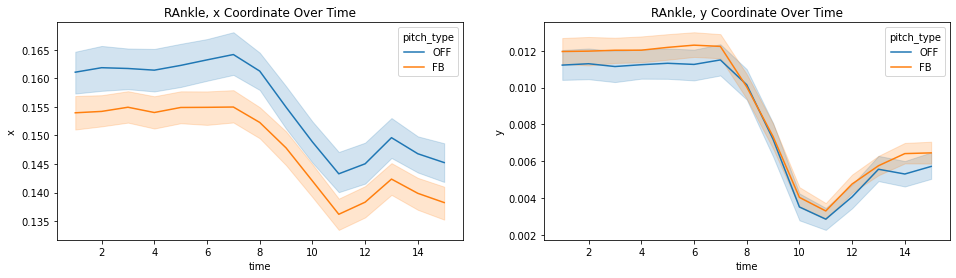

In [14]:
time_plots_by_pitch(glasnow_clean_data, glasnow_pitchtype_dict, "line")

### Saving the Clean Pose Data Along with the Outcome

In [15]:
glasnow_final_data = {}

for play_id in glasnow_clean_data.keys():
    
    # Add pose data, removing the frame numbers and confidence scores
    glasnow_final_data[play_id] = {}
    glasnow_final_data[play_id]['pose_data'] = glasnow_clean_data[play_id]
    for keypoint in glasnow_final_data[play_id]['pose_data']:
        glasnow_final_data[play_id]['pose_data'][keypoint].pop('frame')
        glasnow_final_data[play_id]['pose_data'][keypoint].pop('conf')
    
    # Add outcome data
    # Outcome 1: Simplified/categorized pitch type
    glasnow_final_data[play_id]['outcome1'] = glasnow_pitchtype_dict[play_id]
    
    # Outcome 2: Non-simplified pitch type
    glasnow_final_data[play_id]['outcome2'] = glasnow_pitchtype_all_dict[play_id]
    

In [16]:
# Output json file to store dictionary
with open('../data/modeling-data/modeling-data.glasnow.json', 'w') as f:
    json.dump(glasnow_final_data, f)

## Walker Buehler

In [16]:
# Parameters and inputs
pitcher = 'Walker Buehler'
pitch_hand = 'r'
json_dir = '../data/openpose-json-data/buehler'
json_files = [os.path.join(json_dir, file) for file in os.listdir(json_dir) if '.json' in file]

# Send files through filter and cleaner
buehler_clean_data, buehler_deselected_files = clean_video2data_data(json_files, pitch_hand, pitcher)

Filtering files...

../data/openpose-json-data/buehler/732565c9-31ae-4aa5-bdea-b98e38d84074.json
Not enough frames available... Start Frame: 18, 1st Avail: 19
https://sporty-clips.mlb.com/b0b60e98-fd9d-4629-90ca-1612c31a0d71.mp4

../data/openpose-json-data/buehler/1033bbe0-5080-41f6-a9bf-d58379b57ac7.json
Not enough frames available... Start Frame: 16, 1st Avail: 17
https://sporty-clips.mlb.com/4b478d0e-7bd8-4e85-8e7f-3922d3fed1a3.mp4

../data/openpose-json-data/buehler/3e8c61b7-4423-494f-a697-1eee17a731e7.json
Not enough frames available... Start Frame: 16, 1st Avail: 23
https://sporty-clips.mlb.com/7fca8906-3cb1-4b0a-95c2-82d5fb7ecae3.mp4

../data/openpose-json-data/buehler/1e7ab139-6f17-498f-9676-c12e13a28cc0.json
Not enough frames available... Start Frame: 15, 1st Avail: 25
https://sporty-clips.mlb.com/4e1632e1-4a0e-4b78-a56d-53068acf9d4b.mp4

../data/openpose-json-data/buehler/97037d8c-5092-4a02-88df-6c412eee5c27.json
Not enough frames available... Start Frame: 16, 1st Avail: 24
h

../data/openpose-json-data/buehler/bbc713f8-fcac-418d-81e8-f0fd4399a4c8.json
Not enough frames available... Start Frame: 16, 1st Avail: 19
https://sporty-clips.mlb.com/37f5601b-a0fc-4771-8f7e-34401fd7c956.mp4

../data/openpose-json-data/buehler/fc621566-9756-4d9d-b2ed-6dd9ced7f5dd.json
Not enough frames available... Start Frame: 16, 1st Avail: 22
https://sporty-clips.mlb.com/09f4b029-b4ef-4007-9a67-4f517ef4502b.mp4

../data/openpose-json-data/buehler/52b6fc08-c1dc-4607-9db8-053c07249f74.json
Not enough frames available... Start Frame: 20, 1st Avail: 32
https://sporty-clips.mlb.com/e7a1b2d1-f685-4fe9-a0c1-1289117611ae.mp4

../data/openpose-json-data/buehler/5a773e20-0a83-472e-99b4-8325f4c8f57a.json
Not enough frames available... Start Frame: 19, 1st Avail: 29
https://sporty-clips.mlb.com/880ee457-ba3a-4294-b689-2e1c3b89f678.mp4

../data/openpose-json-data/buehler/e99fe05e-23d9-43d2-b605-bc4099222740.json
Not enough frames available... Start Frame: 16, 1st Avail: 28
https://sporty-clips.

../data/openpose-json-data/buehler/e818f5bd-cc36-4523-8c28-3c20d810ca1e.json
Not enough frames available... Start Frame: 14, 1st Avail: 18
https://sporty-clips.mlb.com/3f118fec-d838-4473-b130-aa0a00718ebc.mp4

../data/openpose-json-data/buehler/3a4caf6a-b7f3-4a47-8b6f-eb42a887af3e.json
Not enough frames available... Start Frame: 16, 1st Avail: 22
https://sporty-clips.mlb.com/4058bcc0-2c64-4ab1-8000-85bd845496cf.mp4

../data/openpose-json-data/buehler/a9ebc0ba-ec1b-4e83-8cd9-00ebb4f000f4.json
Not enough frames available... Start Frame: 16, 1st Avail: 28
https://sporty-clips.mlb.com/776a4e44-1c80-4f01-a15a-02ee71a03509.mp4

../data/openpose-json-data/buehler/7f52a1e9-db20-468e-98e6-fac9282522c8.json
Not enough frames available... Start Frame: 19, 1st Avail: 31
https://sporty-clips.mlb.com/cf537997-97b3-43af-92a5-e74d04f20db0.mp4

../data/openpose-json-data/buehler/af3c187d-b703-4f07-a974-f94583f600a3.json
6.8° angle between knees. Deselecting file...
Leg kick frame: 67
https://sporty-cli

../data/openpose-json-data/buehler/2d1acc9a-3b82-48da-a130-7ad0765f034e.json
Not enough frames available... Start Frame: 16, 1st Avail: 17
https://sporty-clips.mlb.com/8355bcc1-b5ed-478b-9e16-ad6651d9e5b1.mp4

../data/openpose-json-data/buehler/f8278f29-e463-4ff2-8125-ed655733ce81.json
Not enough frames available... Start Frame: 17, 1st Avail: 29
https://sporty-clips.mlb.com/0dbbdf7c-87da-4f99-ba73-b42f160ba08b.mp4

../data/openpose-json-data/buehler/321ced3c-8c79-4804-9128-384aa9ffc07c.json
Not enough frames available... Start Frame: 16, 1st Avail: 18
https://sporty-clips.mlb.com/0d20a86a-8c67-4f16-a391-85d3c8d59d9e.mp4

../data/openpose-json-data/buehler/4390d753-1ca7-4145-bc0c-3fa71309824c.json
Not enough frames available... Start Frame: -8, 1st Avail: 0
https://sporty-clips.mlb.com/4645717b-1cd6-4a43-842b-552acdaa274d.mp4

../data/openpose-json-data/buehler/51c2d601-edcd-4bca-891b-180296201858.json
Not enough frames available... Start Frame: 16, 1st Avail: 18
https://sporty-clips.m

../data/openpose-json-data/buehler/d46f2a89-8f3f-48a9-9e56-3e087d316b44.json
Not enough frames available... Start Frame: 15, 1st Avail: 27
https://sporty-clips.mlb.com/92735a2a-0274-4285-a716-32aa892afac9.mp4

../data/openpose-json-data/buehler/23bca8b9-ab4d-4906-958f-d057a5bb7ecc.json
Not enough frames available... Start Frame: 16, 1st Avail: 28
https://sporty-clips.mlb.com/433860b5-f7fe-4a3b-a4a8-3175b6a2a73d.mp4

../data/openpose-json-data/buehler/1d41b750-942f-4dad-8c62-107ff73a88eb.json
Not enough frames available... Start Frame: 17, 1st Avail: 29
https://sporty-clips.mlb.com/c17700c3-9a24-45ba-8017-26f4629c2e53.mp4

../data/openpose-json-data/buehler/57072d89-a39e-41aa-b1f3-2bda59d7299f.json
Not enough frames available... Start Frame: 15, 1st Avail: 24
https://sporty-clips.mlb.com/3012969a-1c73-40fd-b2ab-d1dcc92bfb1d.mp4

../data/openpose-json-data/buehler/faa22ae0-a81f-4ab2-8ffc-e74cf324a30a.json
Not enough frames available... Start Frame: 15, 1st Avail: 27
https://sporty-clips.

../data/openpose-json-data/buehler/aee62875-7223-4025-b806-d678832dd21d.json
Interpolating values for 1 frame(s) of LAnkle...

../data/openpose-json-data/buehler/a8cfa532-13f9-4fee-b6c4-c3aa9be29e6b.json
Interpolating values for 2 frame(s) of LAnkle...

../data/openpose-json-data/buehler/df116c02-a115-4785-a135-7f21d327b32f.json
Interpolating values for 1 frame(s) of LAnkle...

../data/openpose-json-data/buehler/0fdea2dc-2612-4417-9cc2-922f772c0f11.json
Interpolating values for 1 frame(s) of LAnkle...

../data/openpose-json-data/buehler/231878c3-a3e0-4c7c-8fc3-6cc20f94342a.json
Interpolating values for 1 frame(s) of LAnkle...

../data/openpose-json-data/buehler/2bccad3e-b545-46fb-ae0a-5120baf718f8.json
Interpolating values for 1 frame(s) of LAnkle...

../data/openpose-json-data/buehler/1987d01c-c08b-4708-9b36-cc8573b1696d.json
Interpolating values for 1 frame(s) of LAnkle...

../data/openpose-json-data/buehler/0e54515e-575b-4d49-9c78-956b4ea07a7d.json
Interpolating values for 1 frame(s

In [17]:
buehler_df = pd.read_csv("../data/tabular-data/621111_data.csv")
buehler_df = buehler_df[buehler_df.play_ids.isin(list(buehler_clean_data.keys()))]
buehler_df["pitch_type"].value_counts()

FF    372
FC    164
SL    148
KC    118
SI     49
CH     46
Name: pitch_type, dtype: int64

In [18]:
# Create dictionaries that map video data to a pitch type
# Categorized pitches
buehler_pitchtype_dict = {}
for i, play_id in enumerate(list(buehler_df["play_ids"])):
    pitch_type = list(buehler_df["pitch_type"])[i]
    if pitch_type in ["FA", "FF"]:
        pitch_type = "FB"
    elif pitch_type in ["FT", "FC", "FS", "SI", "SF"]:
        pitch_type = "FBwM"
    else:
        pitch_type = "OFF"
    buehler_pitchtype_dict[play_id] = pitch_type
    
# All pitch types
buehler_pitchtype_all_dict = {}
for i, play_id in enumerate(list(buehler_df["play_ids"])):
    pitch_type = list(buehler_df["pitch_type"])[i]
    buehler_pitchtype_all_dict[play_id] = pitch_type
    

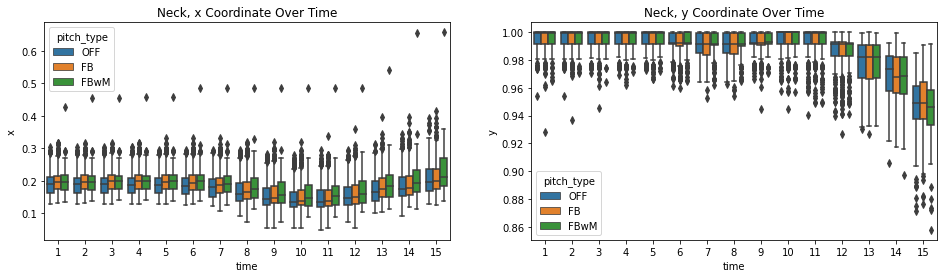

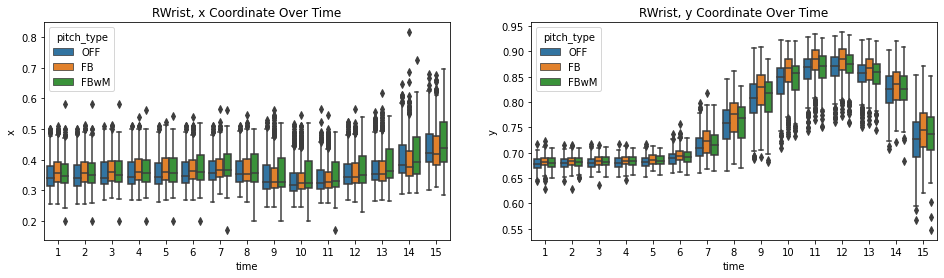

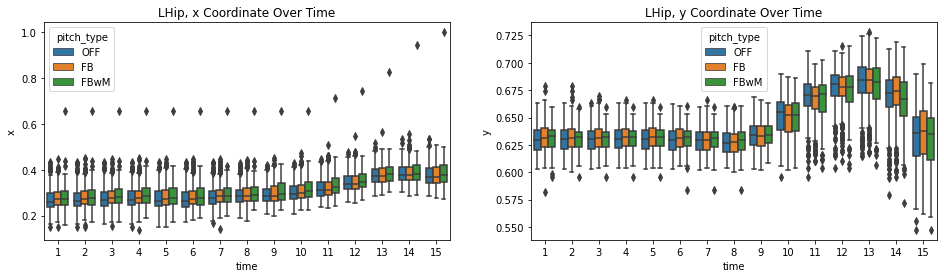

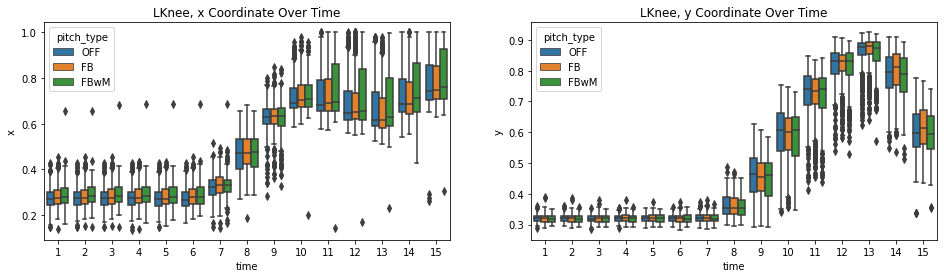

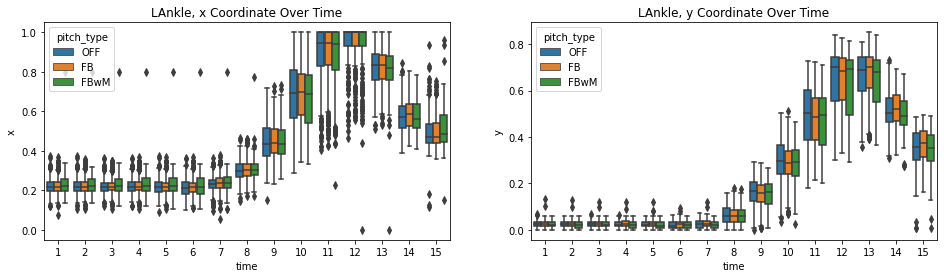

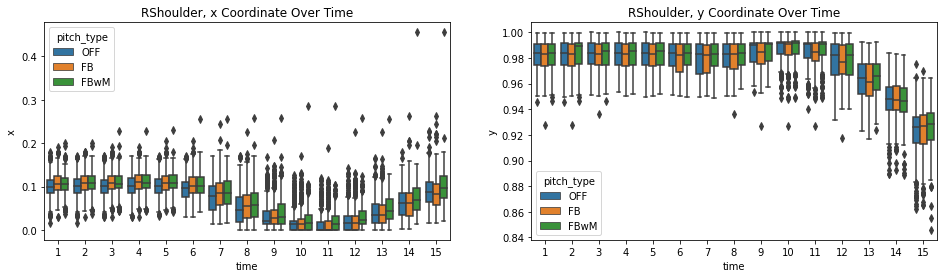

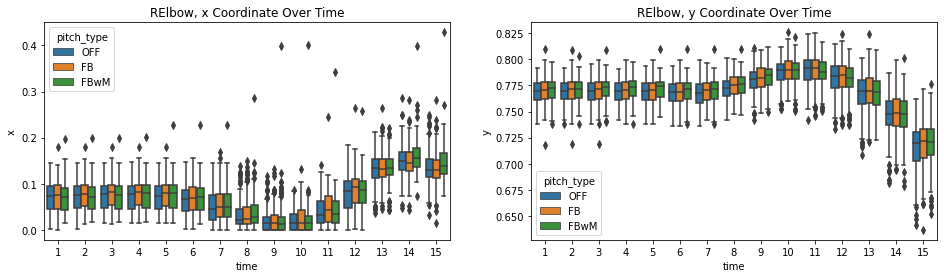

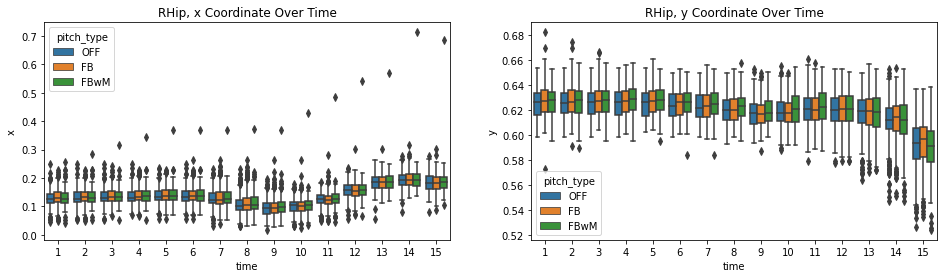

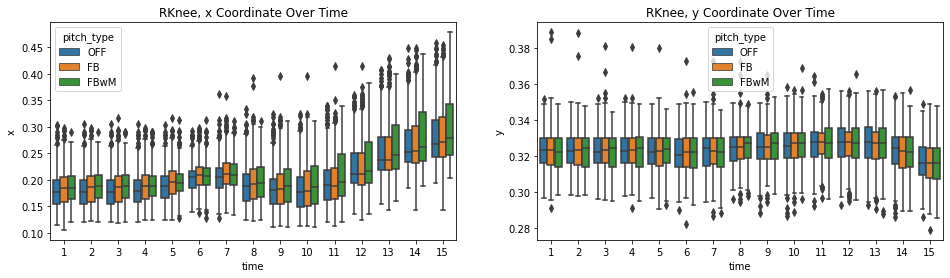

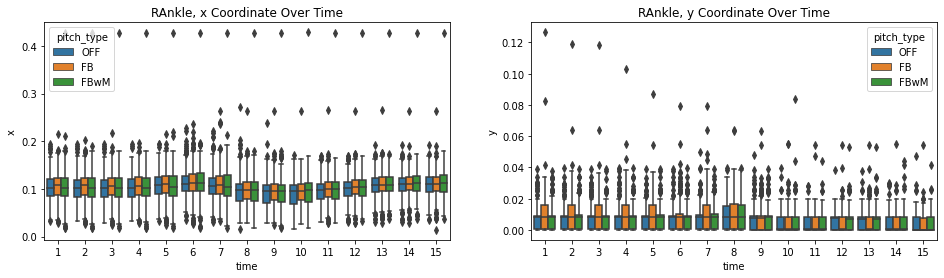

In [19]:
time_plots_by_pitch(buehler_clean_data, buehler_pitchtype_dict, "box")

### Manual Inspection for Errors

In [20]:
# The code below was used to manually inspect all observations for errors - commenting out to reduce memory
#for play_id in buehler_clean_data.keys():

    ## Create df
    #temp_df = pd.DataFrame(buehler_clean_data[play_id]['LKnee'])
    #melted_df = temp_df[['time', 'x', 'y']].melt(id_vars='time')

    ## Plot
    #print(play_id)
    #print(video_link_from_play_id(pitcher, lookup_play_id=play_id) + "\n")
    #fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    #sns.lineplot(data=melted_df, x='time', y='value', hue='variable')
    #ax.set_title(play_id)
    #plt.show()
    

In [21]:
buehler_manual_errors = [
    "db5053d2-fbe9-44f6-b70d-6224c01e4841"
]

In [22]:
len(buehler_clean_data.keys())

897

In [23]:
for play_id in buehler_manual_errors:
    buehler_clean_data.pop(play_id)

In [24]:
len(buehler_clean_data.keys())

896

### Frame-to-Frame Comparison by Pitch Type

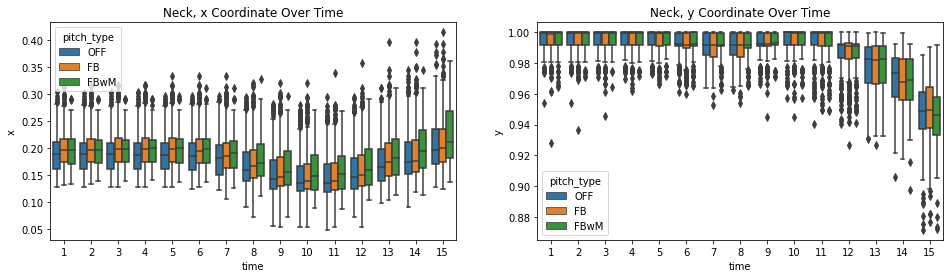

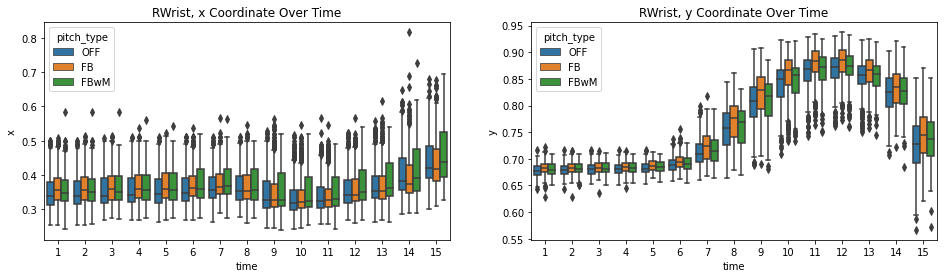

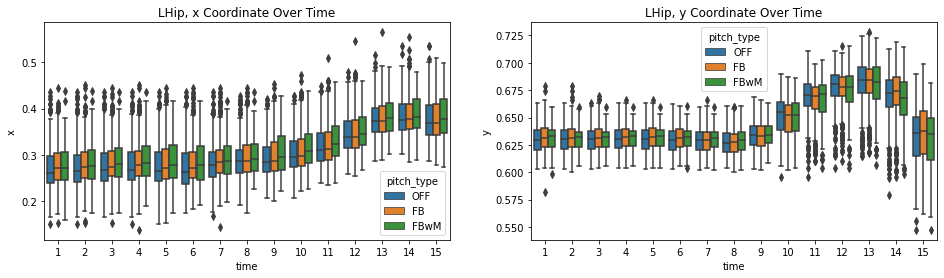

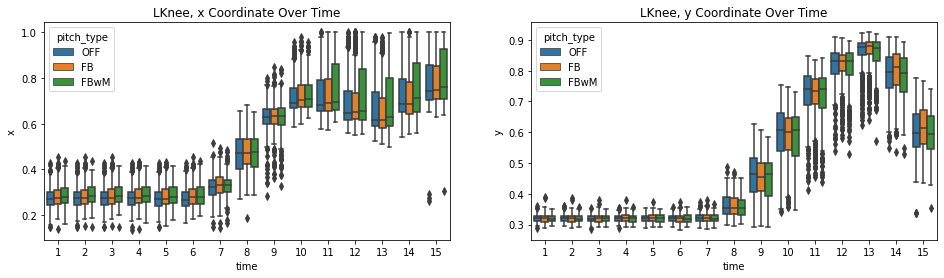

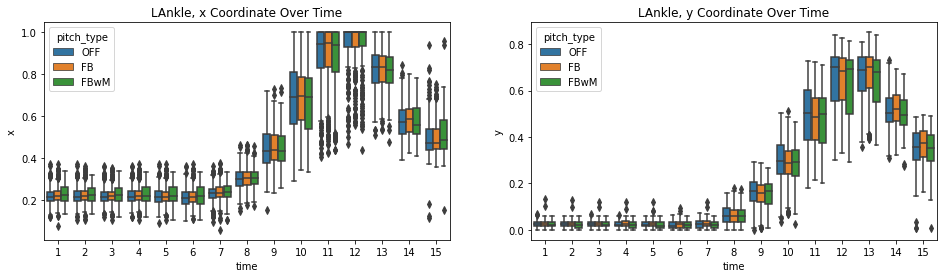

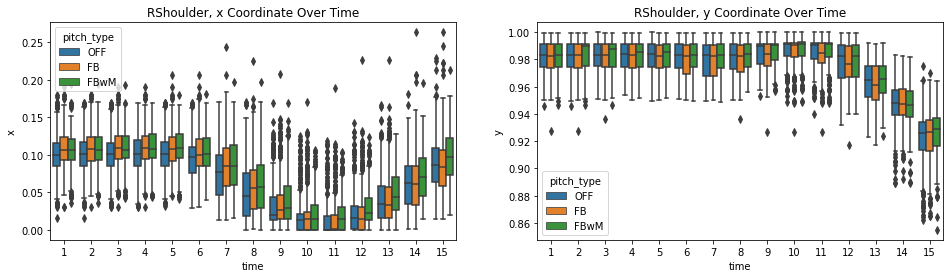

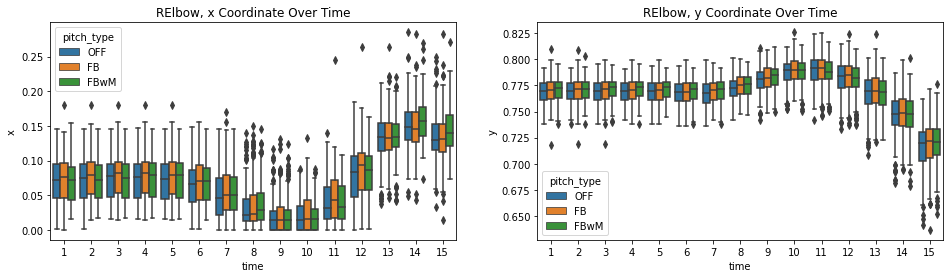

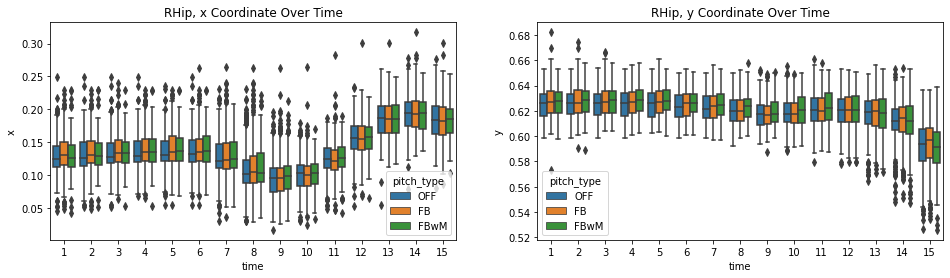

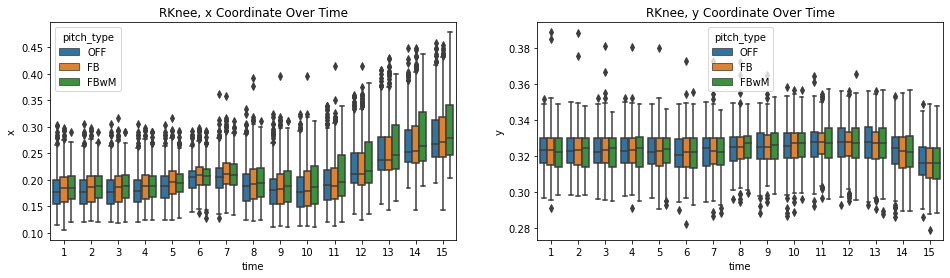

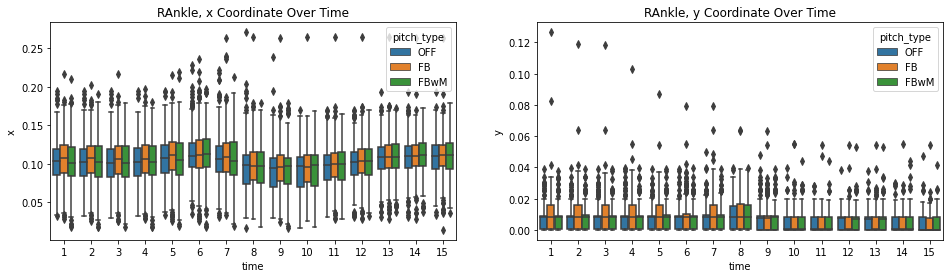

In [25]:
time_plots_by_pitch(buehler_clean_data, buehler_pitchtype_dict, "box")

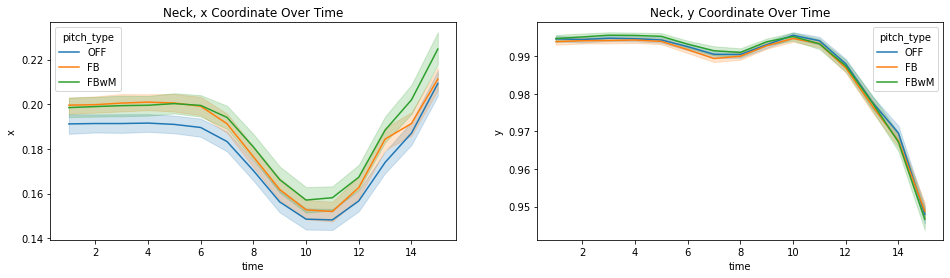

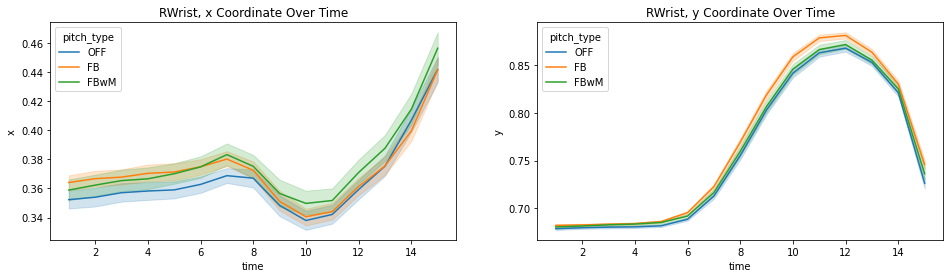

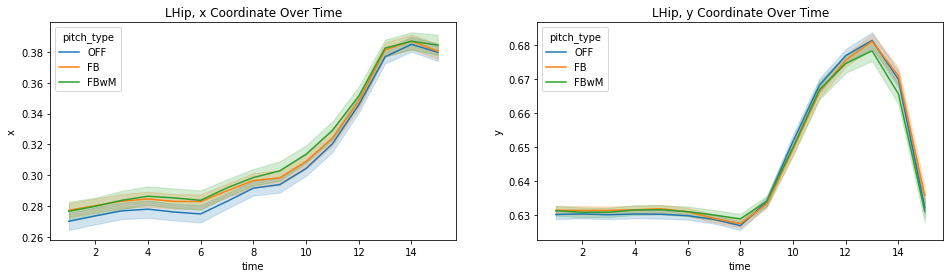

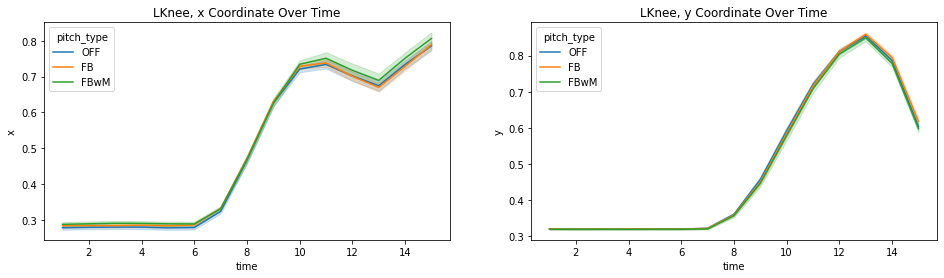

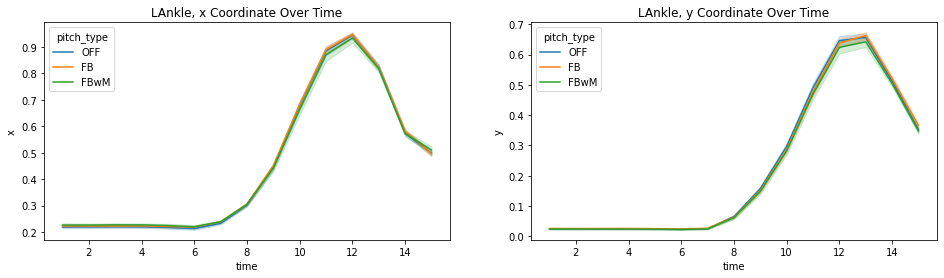

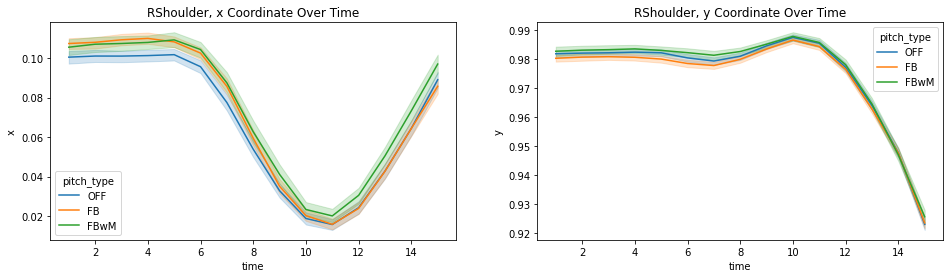

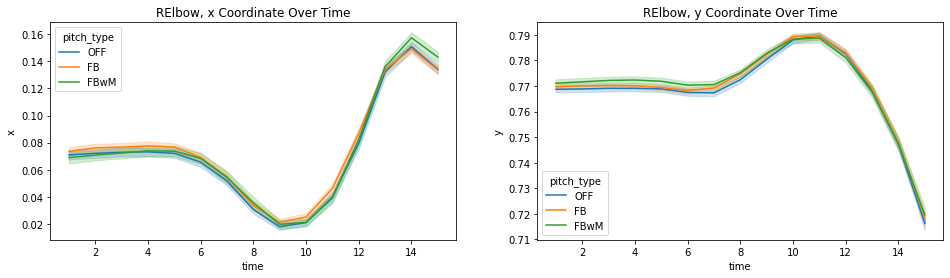

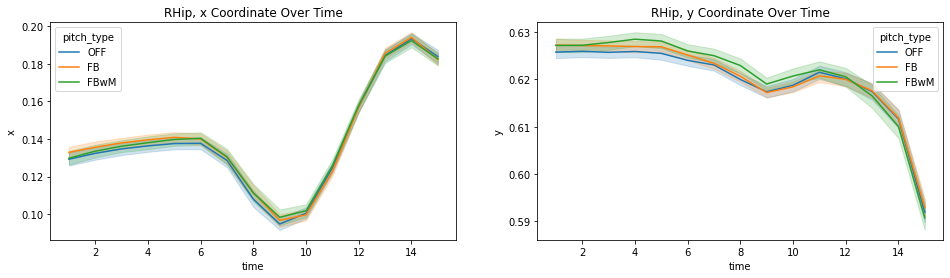

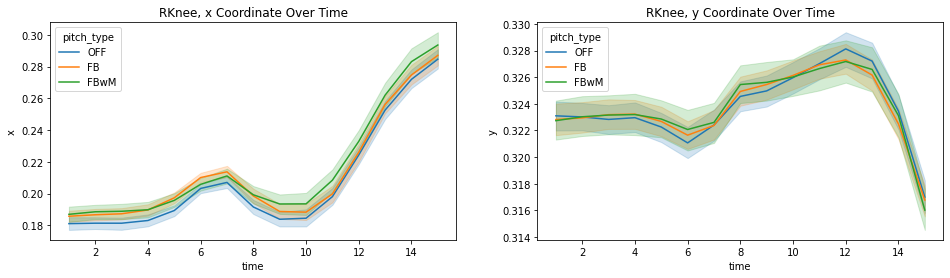

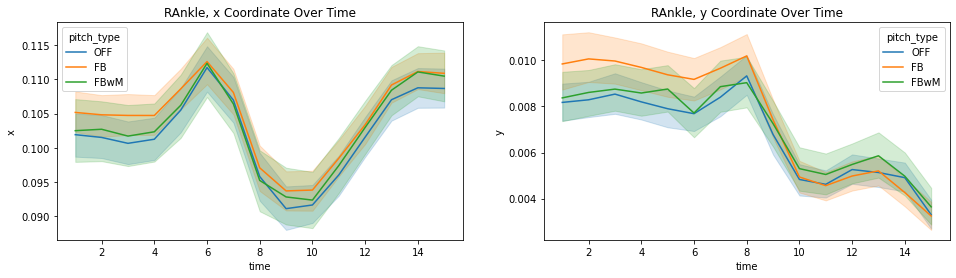

In [26]:
time_plots_by_pitch(buehler_clean_data, buehler_pitchtype_dict, "line")

### Saving the Clean Pose Data Along with the Outcome

In [27]:
buehler_final_data = {}

for play_id in buehler_clean_data.keys():
    
    # Add pose data, removing the frame numbers and confidence scores
    buehler_final_data[play_id] = {}
    buehler_final_data[play_id]['pose_data'] = buehler_clean_data[play_id]
    for keypoint in buehler_final_data[play_id]['pose_data']:
        buehler_final_data[play_id]['pose_data'][keypoint].pop('frame')
        buehler_final_data[play_id]['pose_data'][keypoint].pop('conf')
    
    # Add outcome data
    # Outcome 1: Simplified/categorized pitch type
    buehler_final_data[play_id]['outcome1'] = buehler_pitchtype_dict[play_id]
    
    # Outcome 2: Non-simplified pitch type
    buehler_final_data[play_id]['outcome2'] = buehler_pitchtype_all_dict[play_id]
    

In [29]:
# Output json file to store dictionary
with open('../data/modeling-data/modeling-data.buehler.json', 'w') as f:
    json.dump(buehler_final_data, f)